# Analysis of CLIP Embedding Space

In [1]:
import scanpy as sc
import numpy as np
import h5py
import openslide
import json
from PIL import Image
import anndata as ad
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from torchvision.transforms import functional
import os

## Individual Analysis of Samples

Read preprocessed (genes filtered and ordered) gene expression data

In [2]:
gex_root = "../data/space_ranger_outputs/"
adata1 = sc.read_h5ad(os.path.join(gex_root, "TENX45/gex_filt.h5ad"))
adata2 = sc.read_h5ad(os.path.join(gex_root, "151/gex_filt.h5ad"))
adata3 = sc.read_h5ad(os.path.join(gex_root, "152/gex_filt.h5ad"))
adata4 = sc.read_h5ad(os.path.join(gex_root, "153/gex_filt.h5ad"))
adata5 = sc.read_h5ad(os.path.join(gex_root, "154/gex_filt.h5ad"))
#adata_train = sc.read_h5ad(os.path.join(gex_root, "TENX146/gex_stride5_filt.h5ad"))

Load spatial coordinates of (pseudo-) spots

In [3]:
# Standard Visium
spat1 = pd.read_csv(os.path.join(gex_root, "TENX45/spatial/tissue_positions_list.csv"), header=None, index_col=0)
spat1 = spat1[spat1.loc[:, 1].values.astype(bool)]
spat1 = spat1.loc[adata1.obs_names]
adata1.obsm["spatial"] = spat1.loc[:, [5, 4]].values

spat2 = pd.read_csv(os.path.join(gex_root, "151/spatial/tissue_positions.csv"), index_col=0)
spat2 = spat2[spat2.loc[:, "in_tissue"].values.astype(bool)]
spat2 = spat2.loc[adata2.obs_names]
adata2.obsm["spatial"] = spat2.loc[:, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

spat3 = pd.read_csv(os.path.join(gex_root, "152/spatial/tissue_positions.csv"), index_col=0)
spat3 = spat3[spat3.loc[:, "in_tissue"].values.astype(bool)]
spat3 = spat3.loc[adata3.obs_names]
adata3.obsm["spatial"] = spat3.loc[:, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

spat4 = pd.read_csv(os.path.join(gex_root, "153/spatial/tissue_positions.csv"), index_col=0)
spat4 = spat4[spat4.loc[:, "in_tissue"].values.astype(bool)]
spat4 = spat4.loc[adata4.obs_names]
adata4.obsm["spatial"] = spat4.loc[:, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

spat5 = pd.read_csv(os.path.join(gex_root, "154/spatial/tissue_positions.csv"), index_col=0)
spat5 = spat5[spat5.loc[:, "in_tissue"].values.astype(bool)]
spat5 = spat5.loc[adata5.obs_names]
adata5.obsm["spatial"] = spat5.loc[:, ["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

# # Visium HD -> coordinates pseudo-spot preprocessing
# with h5py.File(os.path.join(gex_root, "TENX146/pairs.h5")) as f:
#     bcs = f["barcode"][:]
#     coords = f["xy"][:]

# bcs = np.array([b.decode("utf-8") for b in bcs])
# adata_train.obsm["spatial"] = coords

In [4]:
def preproc(adata):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
def downscale_img(wsi, scalefactor: float):
    level = wsi.get_best_level_for_downsample(1/scalefactor)
    img = wsi.read_region((0,0), level=level, size = wsi.level_dimensions[level]).convert("RGB")
    scalefactor *= wsi.level_downsamples[level]
    w, h = img.size
    return functional.resize(img, size = (int(h*scalefactor), int(w*scalefactor)))

def get_thumbnail(tif_file: str, s=0.05):
    wsi = openslide.OpenSlide(tif_file)
    img = np.array(downscale_img(wsi, s))
    um_per_px = float(wsi.properties["openslide.mpp-x"])
    return img, um_per_px

Load CLIP embeddings and apply PCA

In [5]:
c_im1 = np.load(os.path.join(gex_root, "TENX45/image_clip_emb_45.npy"))
c_im2 = np.load(os.path.join(gex_root, "151/image_clip_emb_151.npy"))
c_im3 = np.load(os.path.join(gex_root, "152/image_clip_emb_152.npy"))
c_im4 = np.load(os.path.join(gex_root, "153/image_clip_emb_153.npy"))
c_im5 = np.load(os.path.join(gex_root, "154/image_clip_emb_154.npy"))
c_im_train = np.load(os.path.join(gex_root, "TENX146/image_clip_emb_146.npy"))

c_gene1 = np.load(os.path.join(gex_root, "TENX45/gene_clip_emb_45.npy"))
c_gene2 = np.load(os.path.join(gex_root, "151/gene_clip_emb_151.npy"))
c_gene3 = np.load(os.path.join(gex_root, "152/gene_clip_emb_152.npy"))
c_gene4 = np.load(os.path.join(gex_root, "153/gene_clip_emb_153.npy"))
c_gene5 = np.load(os.path.join(gex_root, "154/gene_clip_emb_154.npy"))
c_gene_train = np.load(os.path.join(gex_root, "TENX146/gene_clip_emb_146.npy"))

# Load pca-reduced image embeddings
adata1.obsm["X_clip_image"] = sc.pp.pca(c_im1, n_comps=50)
adata2.obsm["X_clip_image"] = sc.pp.pca(c_im2, n_comps=50)
adata3.obsm["X_clip_image"] = sc.pp.pca(c_im3, n_comps=50)
adata4.obsm["X_clip_image"] = sc.pp.pca(c_im4, n_comps=50)
adata5.obsm["X_clip_image"] = sc.pp.pca(c_im5, n_comps=50)
#adata_train.obsm["X_clip_image"] = sc.pp.pca(c_im_train, n_comps=50)

# Load pca-reduced gene expression embeddings
adata1.obsm["X_clip_gex"] = sc.pp.pca(c_gene1, n_comps=50)
adata2.obsm["X_clip_gex"] = sc.pp.pca(c_gene2, n_comps=50)
adata3.obsm["X_clip_gex"] = sc.pp.pca(c_gene3, n_comps=50)
adata4.obsm["X_clip_gex"] = sc.pp.pca(c_gene4, n_comps=50)
adata5.obsm["X_clip_gex"] = sc.pp.pca(c_gene5, n_comps=50)
#adata_train.obsm["clip_gex"] = sc.pp.pca(c_gene_train, n_comps=50)

Load scGPT embeddings and apply PCA

In [6]:
c_scg1 = np.load(os.path.join(gex_root, "TENX45/scGPT_CP_embs_45.npy"))
c_scg2 = np.load(os.path.join(gex_root, "151/scGPT_CP_embs_151.npy"))
c_scg3 = np.load(os.path.join(gex_root, "152/scGPT_CP_embs_152.npy"))
c_scg4 = np.load(os.path.join(gex_root, "153/scGPT_CP_embs_153.npy"))
c_scg5 = np.load(os.path.join(gex_root, "154/scGPT_CP_embs_154.npy"))
c_scg_train = np.load(os.path.join(gex_root, "TENX146/scGPT_CP_embs_146.npy"))


# Load pca-reduced image embeddings
adata1.obsm["X_scGPT"] = sc.pp.pca(c_scg1, n_comps=50)
adata2.obsm["X_scGPT"] = sc.pp.pca(c_scg2, n_comps=50)
adata3.obsm["X_scGPT"] = sc.pp.pca(c_scg3, n_comps=50)
adata4.obsm["X_scGPT"] = sc.pp.pca(c_scg4, n_comps=50)
adata5.obsm["X_scGPT"] = sc.pp.pca(c_scg5, n_comps=50)
#adata_train.obsm["X_scGPT"] = sc.pp.pca(c_scg_train, n_comps=50)

Get downscaled version of WSIs and original image resolution

In [7]:
scale = 0.05

for a in [adata1, adata2, adata3, adata4, adata5]:
    a.uns["vis"] = {}

adata1.uns["vis"]["image"], adata1.uns["vis"]["um_per_px"] = get_thumbnail("../data/wsis/TENX45.tif", scale)
adata2.uns["vis"]["image"], adata2.uns["vis"]["um_per_px"] = get_thumbnail("../data/wsis/151.tif", scale)
adata3.uns["vis"]["image"], adata3.uns["vis"]["um_per_px"] = get_thumbnail("../data/wsis/152.tif", scale)
adata4.uns["vis"]["image"], adata4.uns["vis"]["um_per_px"] = get_thumbnail("../data/wsis/153.tif", scale)
adata5.uns["vis"]["image"], adata5.uns["vis"]["um_per_px"] = get_thumbnail("../data/wsis/154.tif", scale)

Normalize and log-transform gene expression

In [8]:
for a in [adata1, adata2, adata3, adata4, adata5]:
    preproc(a)
    sc.pp.pca(a)
    sc.pp.neighbors(a, use_rep="X_clip_gex", key_added="neighbors_clip_gex")
    sc.pp.neighbors(a, n_pcs=50, key_added="neighbors_gex")
    sc.pp.neighbors(a, use_rep="X_scGPT", key_added="neighbors_scGPT")

Perform clustering to 5 clusters in CLIP gene expression embedding space and raw gene expression space on each sample separately

In [9]:
for a in [adata1, adata2, adata3, adata4, adata5]:
    sc.tl.leiden(a, key_added="cluster_individual_clip", resolution=0.1, flavor="igraph", n_iterations=2, neighbors_key="neighbors_clip_gex")

# sc.tl.leiden(adata_train, key_added="cluster_individual", resolution=0.05, flavor="igraph", n_iterations=2, neighbors_key="neighbors_clip_gex")

In [20]:
for a in [adata1, adata4, adata5]:
    sc.tl.leiden(a, key_added="cluster_individual_scGPT", resolution=0.15, flavor="igraph", n_iterations=2, neighbors_key="neighbors_scGPT")

sc.tl.leiden(adata2, key_added="cluster_individual_scGPT", resolution=0.19, flavor="igraph", n_iterations=2, neighbors_key="neighbors_scGPT")
sc.tl.leiden(adata3, key_added="cluster_individual_scGPT", resolution=0.2, flavor="igraph", n_iterations=2, neighbors_key="neighbors_scGPT")

In [11]:
sc.tl.leiden(adata1, key_added="cluster_individual_gex", resolution=0.2, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")
sc.tl.leiden(adata2, key_added="cluster_individual_gex", resolution=0.256, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")
sc.tl.leiden(adata3, key_added="cluster_individual_gex", resolution=0.2, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")
sc.tl.leiden(adata4, key_added="cluster_individual_gex", resolution=0.2, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")
sc.tl.leiden(adata5, key_added="cluster_individual_gex", resolution=0.18, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")

Rename clusters in CLIP embedding space to refer to same regions

In [12]:
cluster_mapping_1 = {"0": "3","1": "0", "2":"1", "3":"2", "4":"4"}
cluster_mapping_2 = {"0":"0", "1": "2", "2":"1", "3":"3", "4":"4"}
cluster_mapping_3 = {"0":"1", "1": "0", "2": "2", "3": "4", "4":"3"}
cluster_mapping_4 = {"0":"4", "1": "0", "2": "2", "3": "1", "4":"3"}
cluster_mapping_5 = {"0":"1", "1": "0", "2": "2", "3": "4", "4":"3"}
adata1.obs["cluster_individual_clip"] = adata1.obs["cluster_individual_clip"].cat.rename_categories(cluster_mapping_1).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata2.obs["cluster_individual_clip"] = adata2.obs["cluster_individual_clip"].cat.rename_categories(cluster_mapping_2).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata3.obs["cluster_individual_clip"] = adata3.obs["cluster_individual_clip"].cat.rename_categories(cluster_mapping_3).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata4.obs["cluster_individual_clip"] = adata4.obs["cluster_individual_clip"].cat.rename_categories(cluster_mapping_4).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata5.obs["cluster_individual_clip"] = adata5.obs["cluster_individual_clip"].cat.rename_categories(cluster_mapping_5).cat.reorder_categories(["0", "1", "2", "3", "4"])

In [32]:
cluster_mapping_1 = {"0": "3","1": "0", "2":"1", "3":"2", "4":"4"}
cluster_mapping_2 = {"0":"0", "1": "2", "2":"1", "3":"3", "4":"4"}
cluster_mapping_3 = {"0":"1", "1": "0", "2": "2", "3": "3", "4":"4"}
cluster_mapping_4 = {"0":"4", "1": "0", "2": "2", "3": "1", "4":"3"}
cluster_mapping_5 = {"0":"1", "1": "3", "2": "0", "3": "4", "4":"2"}
adata1.obs["cluster_individual_scGPT"] = adata1.obs["cluster_individual_scGPT"].cat.rename_categories(cluster_mapping_1).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata2.obs["cluster_individual_scGPT"] = adata2.obs["cluster_individual_scGPT"].cat.rename_categories(cluster_mapping_2).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata3.obs["cluster_individual_scGPT"] = adata3.obs["cluster_individual_scGPT"].cat.rename_categories(cluster_mapping_3).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata4.obs["cluster_individual_scGPT"] = adata4.obs["cluster_individual_scGPT"].cat.rename_categories(cluster_mapping_4).cat.reorder_categories(["0", "1", "2", "3", "4"])
adata5.obs["cluster_individual_scGPT"] = adata5.obs["cluster_individual_scGPT"].cat.rename_categories(cluster_mapping_5).cat.reorder_categories(["0", "1", "2", "3", "4"])

Visualize clusters on tissue cuts

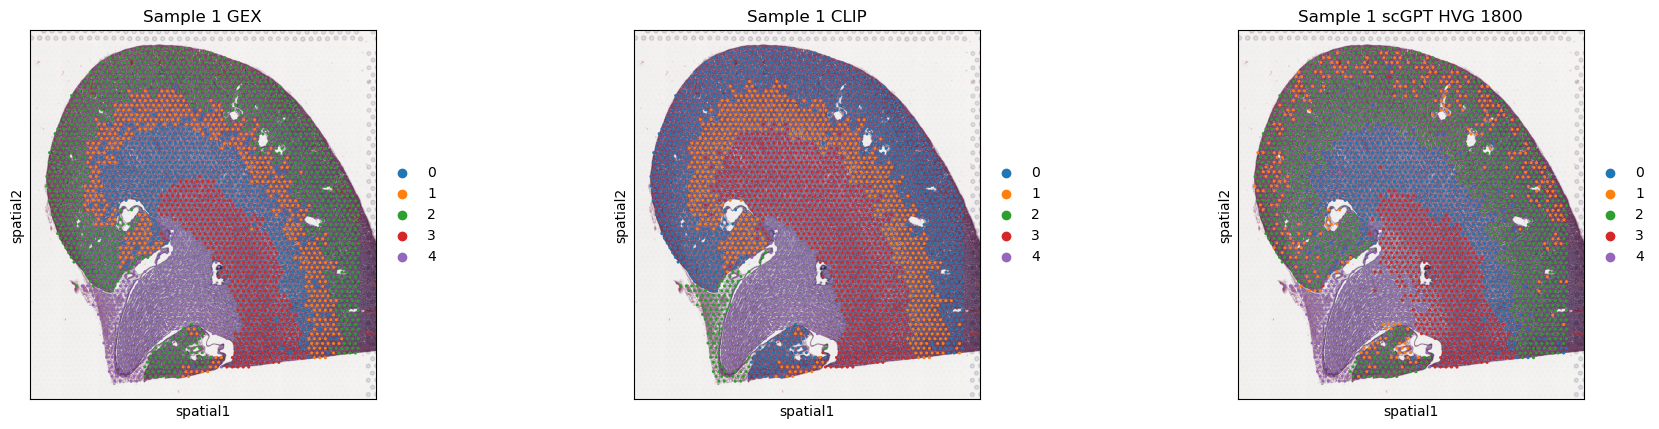

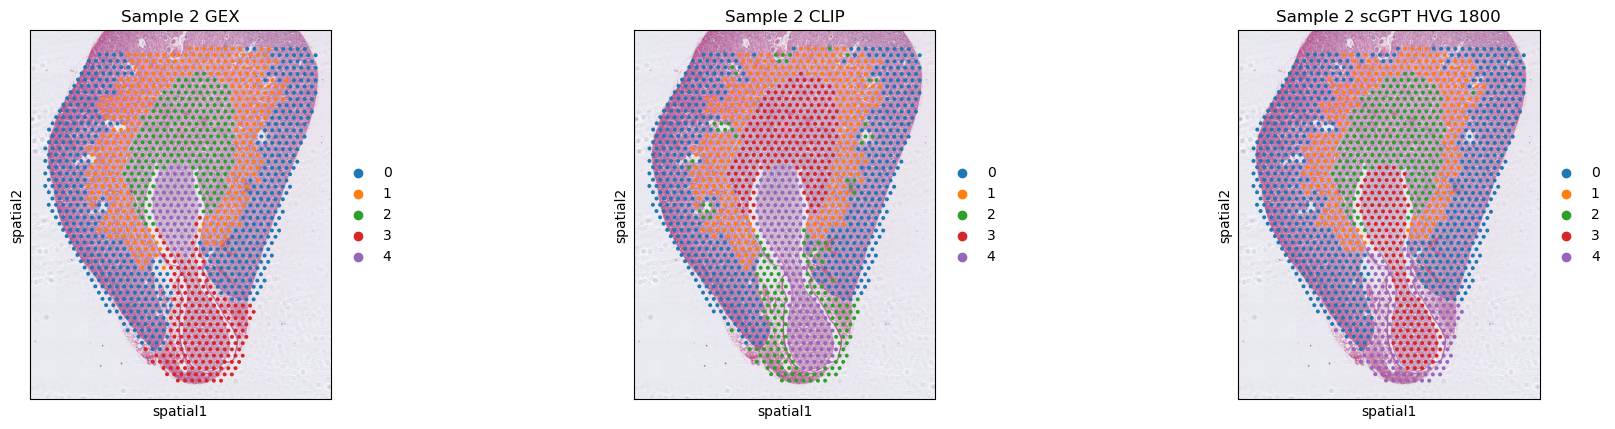

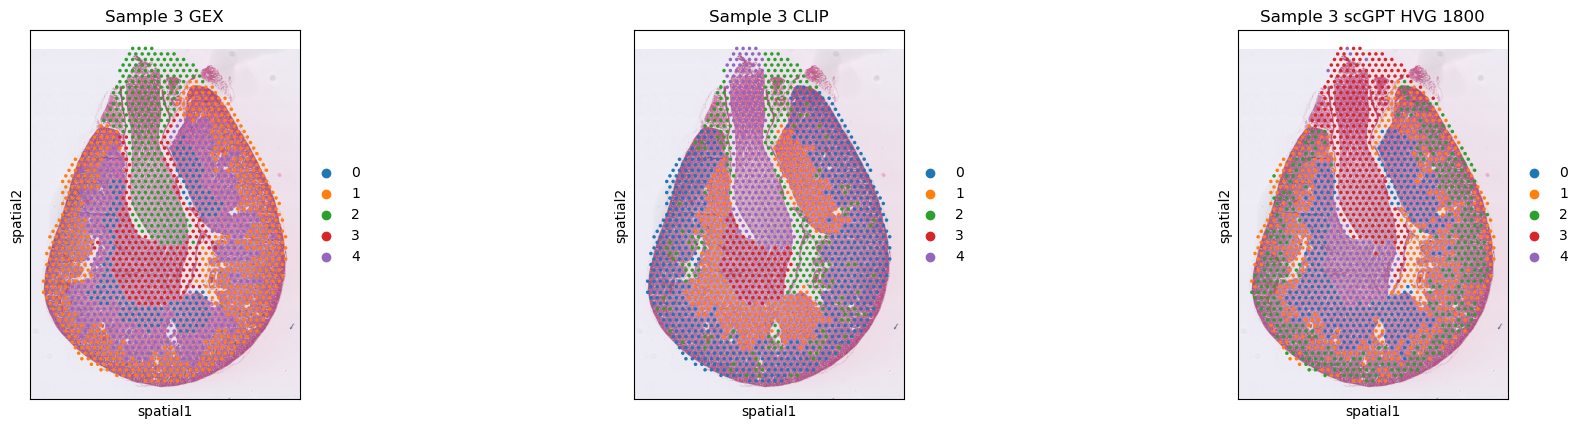

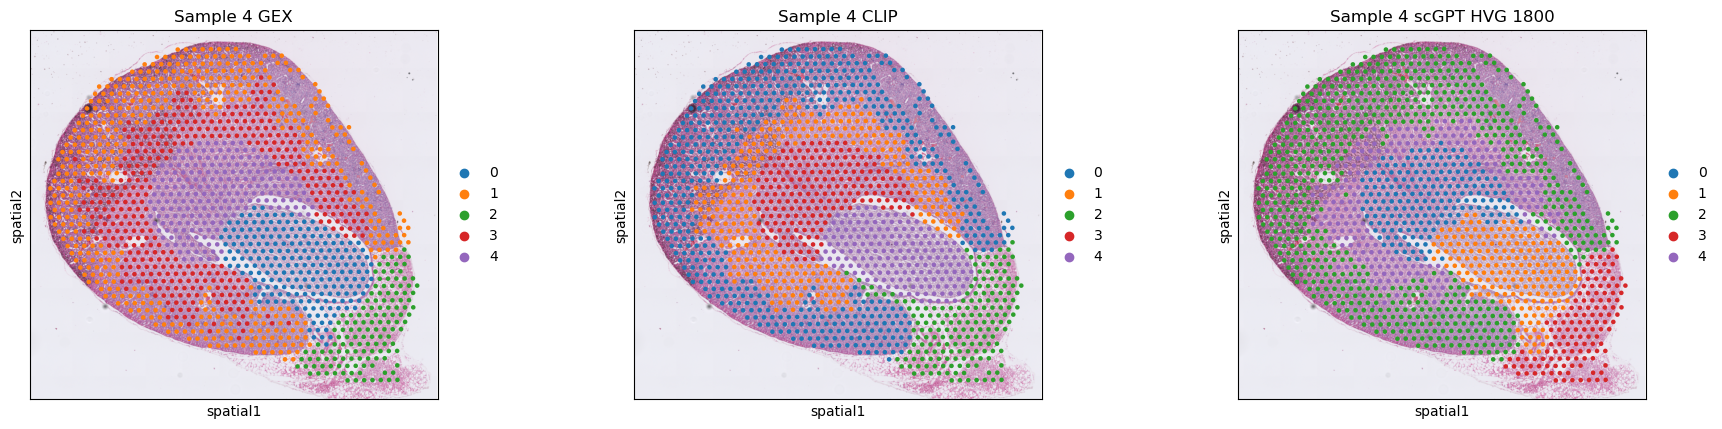

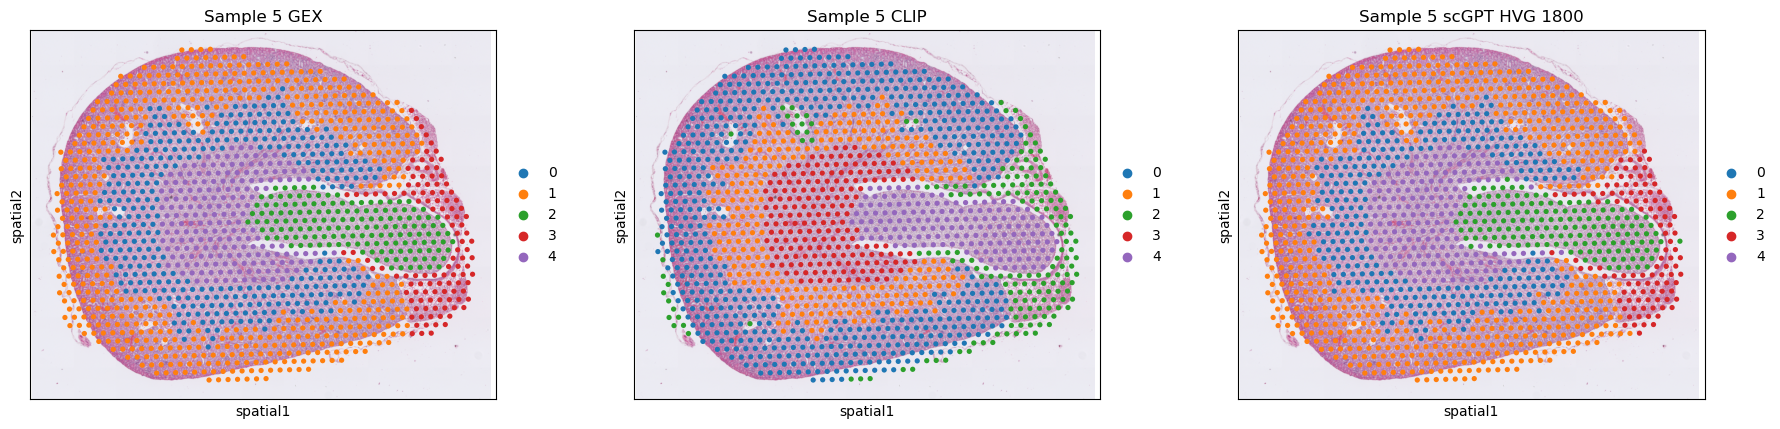

In [21]:
for i, a in enumerate([adata1, adata2, adata3, adata4, adata5]):
    sc.pl.spatial(a, img=a.uns["vis"]["image"], scale_factor=scale, color=["cluster_individual_gex", "cluster_individual_clip", "cluster_individual_scGPT"], spot_size=55 / a.uns["vis"]["um_per_px"], show=True, title=[f"Sample {i+1} GEX", f"Sample {i+1} CLIP", f"Sample {i+1} scGPT HVG 1800"])

## Joint Analysis of Samples

Concatenate all samples and perform clustering on joint clip embeddings and joint gene expression

In [28]:
adata = adata1.concatenate(adata2, adata3,adata4,adata5, batch_categories=["sample 1", "sample 2","sample 3" , "sample 4", "sample 5"], batch_key="sample")
adata.obs.cluster_individual_clip = adata.obs.cluster_individual_clip.cat.rename_categories({"0": "Cortex", "1": "OSOM", "2": "Adipose tissue", "3": "ISOM", "4": "Inner Medulla & Papilla"})

# Load UMAP-reduced embeddings
adata.obsm["X_clip_gex"] = sc.pp.pca(np.concatenate([c_gene1, c_gene2, c_gene3, c_gene4, c_gene5], axis=0), n_comps=50, random_state=0)
adata.obsm["X_clip_image"] = sc.pp.pca(np.concatenate([c_im1, c_im2, c_im3, c_im4, c_im5], axis=0), n_comps=50, random_state=0)
adata.obsm["X_scGPT"] = sc.pp.pca(np.concatenate([c_scg1, c_scg2, c_scg3, c_scg4, c_scg5], axis=0), n_comps=50, random_state=0)

# PCA + Clustering
sc.pp.pca(adata, random_state=0)
sc.pp.neighbors(adata, n_pcs=50, key_added="neighbors_gex")
sc.pp.neighbors(adata, use_rep="X_clip_gex", key_added="neighbors_clip_gex")
sc.pp.neighbors(adata, use_rep="X_clip_image", key_added="neighbors_clip_image")
sc.pp.neighbors(adata, use_rep="X_scGPT", key_added="neighbors_scGPT")
sc.tl.leiden(adata, key_added="cluster_joint_clip_gex", resolution=0.1, flavor="igraph", n_iterations=2, neighbors_key="neighbors_clip_gex")
sc.tl.leiden(adata, key_added="cluster_joint_gex", resolution=0.04, flavor="igraph", n_iterations=2, neighbors_key="neighbors_gex")
sc.tl.leiden(adata, key_added="cluster_joint_scGPT", resolution=0.1, flavor="igraph", n_iterations=2, neighbors_key="neighbors_scGPT")

/tmp/ipykernel_590238/2253707163.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata1.concatenate(adata2, adata3,adata4,adata5, batch_categories=["sample 1", "sample 2","sample 3" , "sample 4", "sample 5"], batch_key="sample")


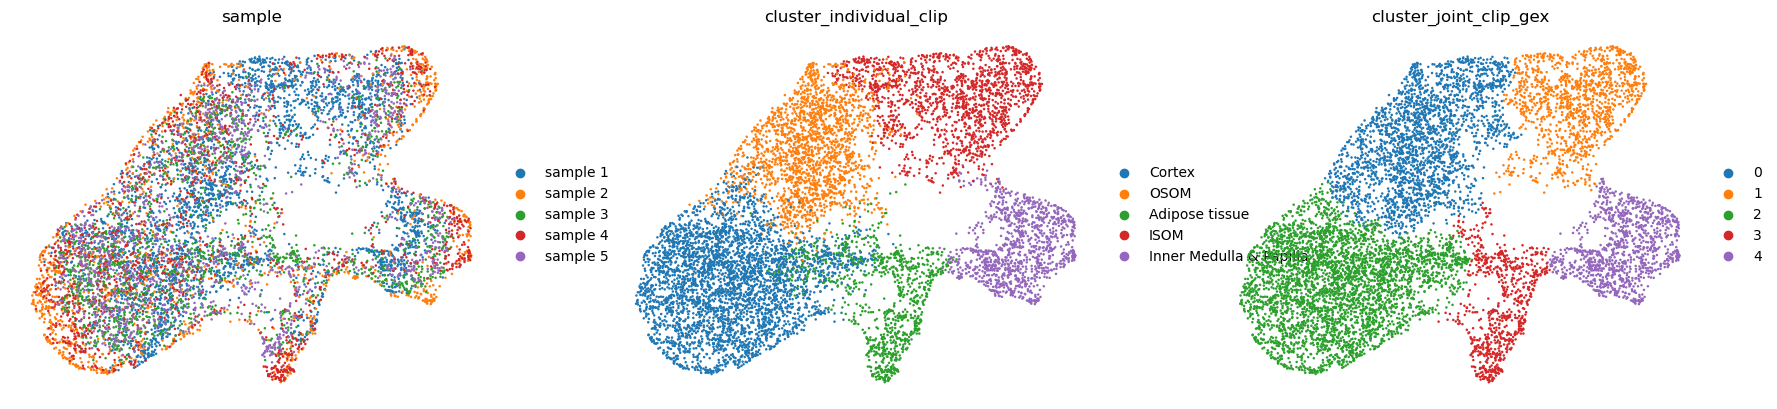

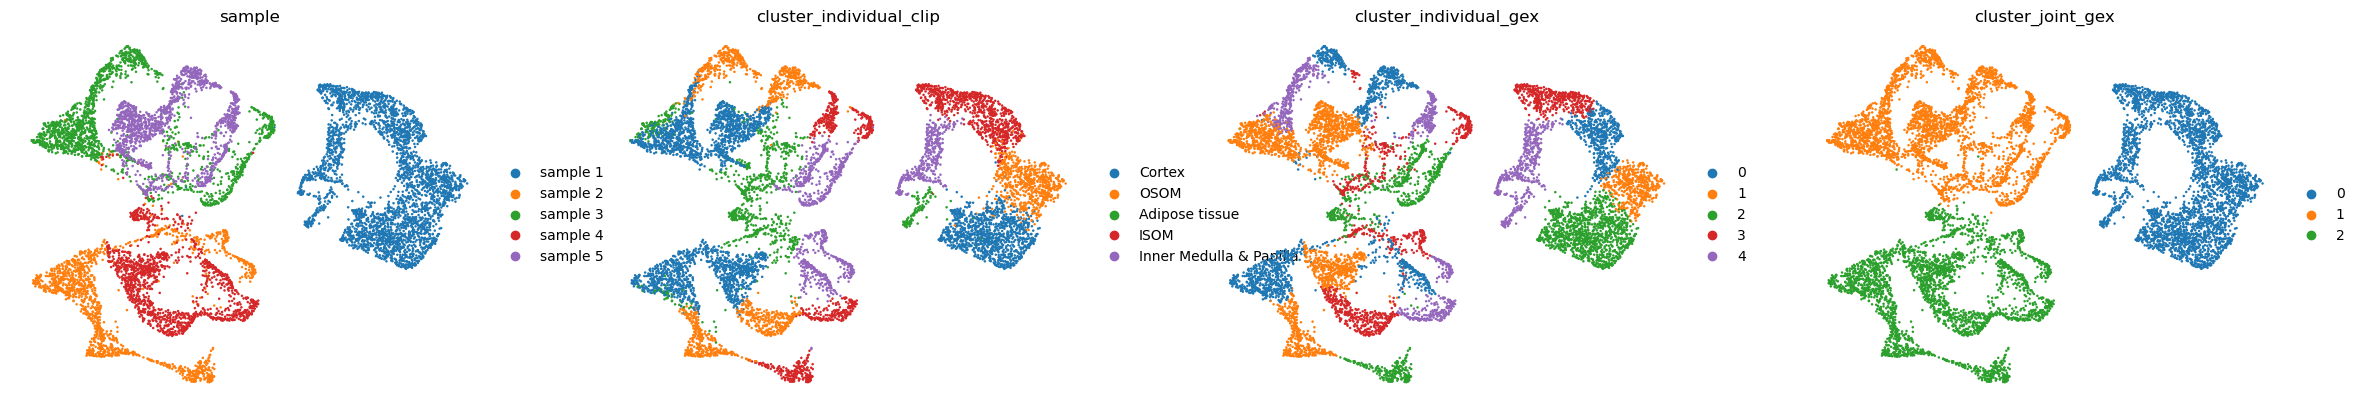

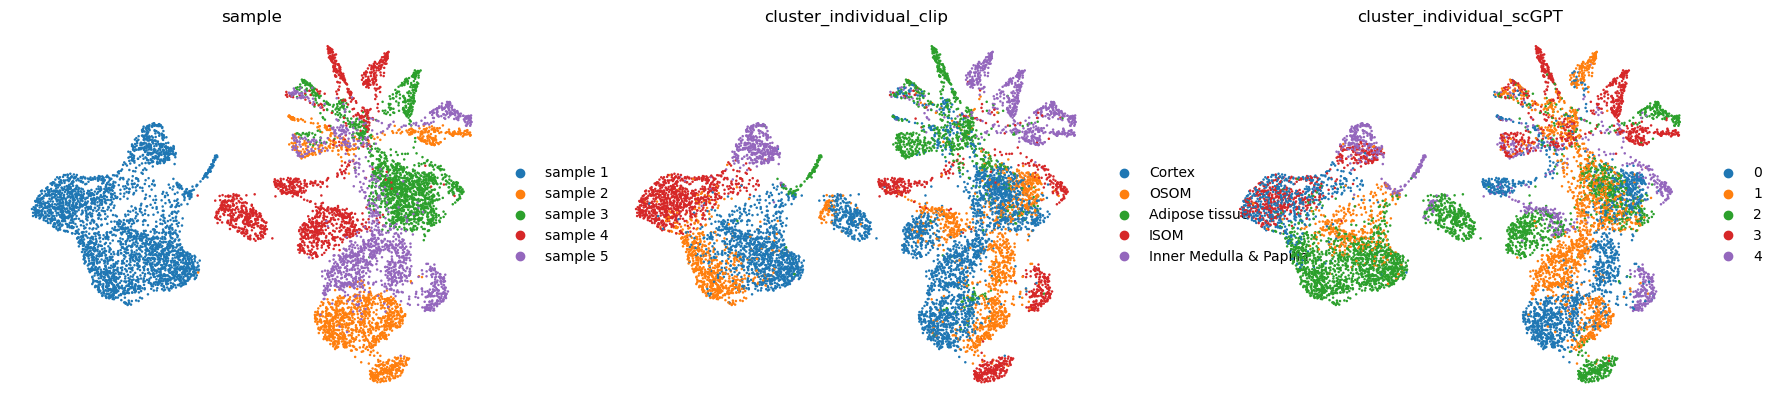

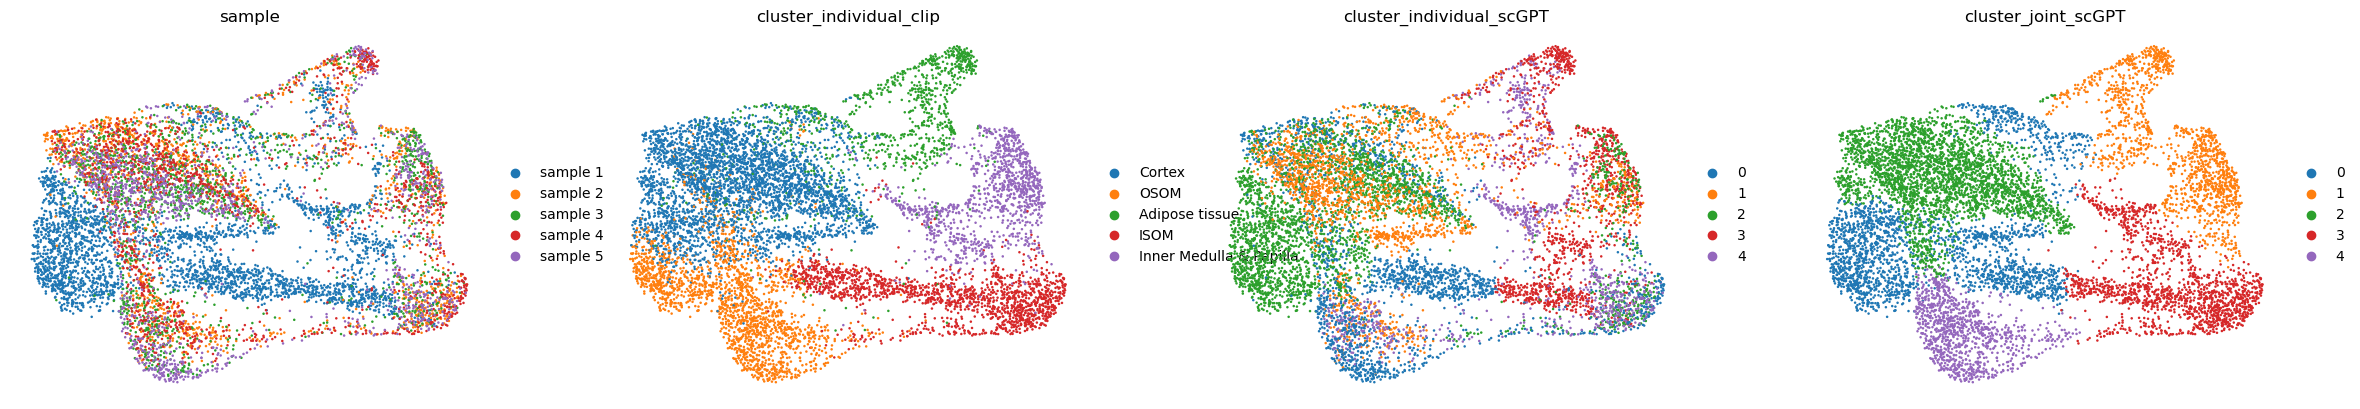

In [29]:
sc.tl.umap(adata, neighbors_key="neighbors_clip_gex", random_state=0)
sc.pl.umap(
    adata,
    color=["sample", "cluster_individual_clip", "cluster_joint_clip_gex"],
    frameon=False,
    ncols=4,
)
sc.tl.umap(adata, neighbors_key="neighbors_gex", random_state=0)
sc.pl.umap(
    adata,
    color=["sample", "cluster_individual_clip", "cluster_individual_gex", "cluster_joint_gex"],
    frameon=False,
    ncols=4,
)
sc.tl.umap(adata, neighbors_key="neighbors_clip_image", random_state=0)
sc.pl.umap(
    adata,
    color=["sample", "cluster_individual_clip", "cluster_individual_scGPT"],
    frameon=False,
    ncols=4,
)
sc.tl.umap(adata, neighbors_key="neighbors_scGPT", random_state=0)
sc.pl.umap(
    adata,
    color=["sample", "cluster_individual_clip", "cluster_individual_scGPT", "cluster_joint_scGPT"],
    frameon=False,
    ncols=4,
)

In [33]:
print("ARI cluster_individual_clip vs. cluster_joint_clip_gex:" , adjusted_rand_score(adata.obs.cluster_individual_clip, adata.obs.cluster_joint_clip_gex.values))
print("ARI sample vs. clusters_joint_clip_gex:" , adjusted_rand_score(adata.obs["sample"].values, adata.obs.cluster_joint_clip_gex.values))
print("ARI cluster_individual_clip vs. cluster_joint_gex:" , adjusted_rand_score(adata.obs.cluster_individual_clip.values, adata.obs.cluster_joint_gex.values))
print("ARI sample vs. cluster_joint_gex:" , adjusted_rand_score(adata.obs["sample"].values, adata.obs.cluster_joint_gex.values))
print("ARI cluster_individual_clip vs. cluster_joint_scGPT:" , adjusted_rand_score(adata.obs.cluster_individual_clip.values, adata.obs.cluster_joint_scGPT.values))
print("ARI sample vs. cluster_joint_scGPT:" , adjusted_rand_score(adata.obs["sample"].values, adata.obs.cluster_joint_scGPT.values))

ARI cluster_individual_clip vs. cluster_joint_clip_gex: 0.8000214989460298
ARI sample vs. clusters_joint_clip_gex: 0.007350548601125194
ARI cluster_individual_clip vs. cluster_joint_gex: 0.014770543458795637
ARI sample vs. cluster_joint_gex: 0.7257562966121339
ARI cluster_individual_clip vs. cluster_joint_scGPT: 0.4534123933291209
ARI sample vs. cluster_joint_scGPT: 0.21753497935932853


In [ ]:
def stratify(adata, n_samples: int, obs_key: str):
    """Get a mask that samples the same number of data points from each cluster"""
    strata = adata.obs[obs_key]
    cts = strata.value_counts()

    # remove clusters with too few points
    small = cts[cts < n_samples].index.to_list()
    print(f"Filtering out clusters {small} (have less than {n_samples} samples)", flush=True)
    msk = np.ones(len(strata), dtype=bool)
    for c in small:
        msk = msk & (strata != c)

    pos_to_keep = np.arange(adata.n_obs, dtype=int)[msk]
    adata = adata[msk]
    cts = cts[cts >= n_samples]
    strata = adata.obs[obs_key]

    # sample the same number of points from each strata
    msk = np.zeros(adata.n_obs, dtype=bool)
    for c, n in zip(cts.index.to_list(), cts.to_list()):
        idx = np.arange(adata.n_obs, dtype=int)[strata == c][np.random.choice(n, size=n_samples, replace=False).astype(int)]
        msk[idx] = True

    return pos_to_keep[msk]